In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json
from itertools import islice

RATIO = 0.7
MIN_SIZE = 1000

## build dataframe with graph analysis data
- only take ASs with minimum LCC coverage
- remove columns containing distributions

In [2]:
analysis_df = pd.read_csv("analysis_2020_08/analysis.tsv", delimiter="\t", index_col=0).dropna(how="all", subset=["avg_coreness", "graph_coreness", "core_order", "density_lcc", "assortativity_lcc", "transitivity_lcc", "avg_shortest_path_len", "approx_avg_shortest_path_len"]).drop(columns=["ri_pp_ifs_dis", "ri_tot_neighs_dis", "dis_leaf1_aggr_type", "dis_leaf_aggr_leaf1_num", "re_pp_ifs_dis", "re_tot_neighs_dis"])
analysis_df

,ds_nodes,ds_links,largest_cc_size,largest_cc_coverage,as_routers,non_as_routers,leaf1,leaf2,default,border,...,re_tot_tot_neighs,avg_coreness,graph_coreness,core_order,density_lcc,assortativity_lcc,transitivity_lcc,avg_shortest_path_len,approx_avg_shortest_path_len,time_to_analyze
as_number,,,,,,,,,,,,,,,,,,,,,
42248,1000,1264,1036,0.994242,1000,42,957,5,4,34,...,124,1.162162,7.0,10.0,0.002175,-0.789422,0.017278,NaN,3.724659,7.668886
6663,1002,16492,4987,0.984989,1002,4061,762,49,31,160,...,9603,2.246240,14.0,38.0,0.000887,-0.479925,0.022093,NaN,3.244771,227.866007
13591,1002,2982,2264,0.958510,1002,1360,700,92,66,144,...,1883,1.258392,5.0,12.0,0.001085,-0.426800,0.008879,NaN,4.488884,37.121452
50542,1003,1362,1321,0.992487,1003,328,702,3,3,295,...,626,1.041635,2.0,55.0,0.001553,-0.560850,0.000115,NaN,3.048465,12.558716
4663,1006,2131,1555,0.962252,1006,610,661,15,20,310,...,960,1.221865,10.0,11.0,0.001522,-0.305545,0.027635,NaN,4.050626,16.616252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,581362,754669,616334,0.988900,581362,41890,559485,2733,883,18261,...,107585,1.111151,21.0,28.0,0.000004,-0.508758,0.000784,NaN,3.978321,39894.204188
5089,586305,930335,900741,0.989618,586305,323886,262811,5857,894,316743,...,648144,1.044029,6.0,7.0,0.000002,-0.219191,0.000014,NaN,5.125428,67688.657558
209,674414,1309172,825689,0.988111,674414,161210,534501,12243,2379,125291,...,639783,1.478631,48.0,70.0,0.000004,-0.319592,0.003252,NaN,5.216719,73153.831827


## classify ASs by main continent or global

In [4]:
with open("stats/geo_continent_data.json", "r", encoding="utf8") as file_in:
    geo_all_dict = json.load(file_in)
geo_dict = dict()
continent_count = {
    "NA": 0,
    "SA": 0,
    "EU": 0,
    "AF": 0,
    "AS": 0,
    "OC": 0,
    "AN": 0,
    "MANY": 0
}
for as_num, data in geo_all_dict.items():
    # if data["tot_nodes_count"] < MIN_SIZE:
    #     pass
    if data["NA_nodes_count"] >= RATIO * data["tot_nodes_count"]:
        geo_dict[as_num] = "NA"
        continent_count["NA"] += 1
    elif data["SA_nodes_count"] >= RATIO * data["tot_nodes_count"]:
        geo_dict[as_num] = "SA"
        continent_count["SA"] += 1
    elif data["EU_nodes_count"] >= RATIO * data["tot_nodes_count"]:
        geo_dict[as_num] = "EU"
        continent_count["EU"] += 1
    elif data["AF_nodes_count"] >= RATIO * data["tot_nodes_count"]:
        geo_dict[as_num] = "AF"
        continent_count["AF"] += 1
    elif data["AS_nodes_count"] >= RATIO * data["tot_nodes_count"]:
        geo_dict[as_num] = "AS"
        continent_count["AS"] += 1
    elif data["OC_nodes_count"] >= RATIO * data["tot_nodes_count"]:
        geo_dict[as_num] = "OC"
        continent_count["OC"] += 1
    elif data["AN_nodes_count"] >= RATIO * data["tot_nodes_count"]:
        geo_dict[as_num] = "AN"
        continent_count["AN"] += 1
    else:
        geo_dict[as_num] = "MANY"
        continent_count["MANY"] += 1

'''

geo_dict:

{'11814': 'NA',
 '31655': 'EU',
 '9381': 'AS',
 '13489': 'SA',
 ...}

'''
continent_count

{'NA': 17656,
 'SA': 7574,
 'EU': 22280,
 'AF': 1239,
 'AS': 9960,
 'OC': 1790,
 'AN': 0,
 'MANY': 1582}

## 1 different analysis dataframe for every continent

In [4]:
df_NA = pd.DataFrame()
df_SA = pd.DataFrame()
df_EU = pd.DataFrame()
df_AF = pd.DataFrame()
df_AS = pd.DataFrame()
df_OC = pd.DataFrame()
df_MANY = pd.DataFrame()
for index, row in analysis_df.iterrows():
    as_number = str(index)
    if as_number not in geo_dict:
        pass
    elif geo_dict[as_number] == "NA":
        df_NA = df_NA.append(row)
    elif geo_dict[as_number] == "SA":
        df_SA = df_SA.append(row)
    elif geo_dict[as_number] == "EU":
        df_EU = df_EU.append(row)
    elif geo_dict[as_number] == "AF":
        df_AF = df_AF.append(row)
    elif geo_dict[as_number] == "AS":
        df_AS = df_AS.append(row)
    elif geo_dict[as_number] == "OC":
        df_OC = df_OC.append(row)
    elif geo_dict[as_number] == "MANY":
        df_MANY = df_MANY.append(row)

# save to csv
with open("analysis_2020_08/analysis_NA.csv", "w", encoding="utf8") as out_file:
    df_NA.to_csv(out_file)
with open("analysis_2020_08/analysis_SA.csv", "w", encoding="utf8") as out_file:
    df_SA.to_csv(out_file)
with open("analysis_2020_08/analysis_EU.csv", "w", encoding="utf8") as out_file:
    df_EU.to_csv(out_file)
with open("analysis_2020_08/analysis_AF.csv", "w", encoding="utf8") as out_file:
    df_AF.to_csv(out_file)
with open("analysis_2020_08/analysis_AS.csv", "w", encoding="utf8") as out_file:
    df_AS.to_csv(out_file)
with open("analysis_2020_08/analysis_OC.csv", "w", encoding="utf8") as out_file:
    df_OC.to_csv(out_file)
with open("analysis_2020_08/analysis_MANY.csv", "w", encoding="utf8") as out_file:
    df_MANY.to_csv(out_file)

df_MANY

,approx_avg_shortest_path_len,as_routers,assortativity_lcc,avg_coreness,avg_leaf1_per_leaf1_aggr,avg_shortest_path_len,border,core_order,default,density_lcc,...,re_tot_tot_neighs,ri_avg_pp_ifs,ri_avg_tot_neighs,ri_leaf1_aggr,ri_max_pp_ifs,ri_max_tot_neighs,ri_tot_pp_ifs,ri_tot_tot_neighs,time_to_analyze,transitivity_lcc
52468,3.346077,1114.0,-0.443754,1.622713,10.906977,NaN,634.0,14.0,2.0,0.000528,...,9211.0,9.511,9.511,43.0,2002.0,2002.0,10595.0,10595.0,294.960451,0.007187
10310,5.965183,1378.0,-0.214850,3.474260,1.949807,NaN,706.0,22.0,120.0,0.001868,...,6167.0,11.287,11.287,259.0,108.0,108.0,15553.0,15553.0,114.930485,0.258544
23033,3.748785,1639.0,-0.383179,1.103036,29.738095,NaN,357.0,8.0,18.0,0.000999,...,1052.0,2.287,2.287,42.0,593.0,593.0,3748.0,3748.0,31.208034,0.002440
4651,3.317137,2134.0,-0.426953,1.820552,73.115385,NaN,142.0,21.0,19.0,0.000617,...,8245.0,6.087,6.087,26.0,1807.0,1807.0,12989.0,12989.0,271.322490,0.009624
63199,4.480533,2452.0,-0.478170,1.316156,25.905882,NaN,197.0,17.0,23.0,0.000867,...,861.0,2.662,2.662,85.0,283.0,283.0,6527.0,6527.0,55.830603,0.037422
9354,4.532430,2694.0,-0.274910,1.727191,16.073826,NaN,191.0,32.0,63.0,0.001010,...,2960.0,3.104,3.104,149.0,1530.0,1530.0,8362.0,8362.0,90.583555,0.020806
8781,3.514228,4337.0,-0.285773,1.582252,10.988201,NaN,274.0,33.0,89.0,0.000193,...,17883.0,7.002,7.002,339.0,5251.0,5251.0,30369.0,30369.0,1004.920903,0.009984
37457,4.387058,4747.0,-0.439112,1.381501,5.769932,4.386694,2190.0,115.0,5.0,0.000272,...,11551.0,3.581,3.581,439.0,1599.0,1599.0,16999.0,16999.0,1135.672900,0.004282
6453,3.740802,4916.0,-0.128532,2.165791,6.455969,NaN,1305.0,161.0,115.0,0.000019,...,467355.0,103.627,103.627,511.0,37393.0,37393.0,509431.0,509431.0,30313.191096,0.003857
22822,5.519552,5435.0,-0.296395,1.326497,19.036437,NaN,422.0,19.0,125.0,0.000384,...,2392.0,2.739,2.739,247.0,308.0,308.0,14884.0,14884.0,311.856907,0.027040


## plot statistics for every continent...
use plotter notebook

## Average stats for each continent

In [5]:
continents = dict()
for continent, count in continent_count.items():
    continent_dict = dict()
    for column in analysis_df.columns:
        continent_dict[column] = 0
    continent_dict["count"] = 0
    continents[continent] = continent_dict
for index, row in analysis_df.iterrows():
    as_number = str(index)
    if as_number not in geo_dict:
        continue
    continent = geo_dict[as_number]
    for column in analysis_df.columns:
        continents[continent][column] = continents[continent][column] + row[column]
    continents[continent]["count"] = continents[continent]["count"] + 1
# average
for continent, row in continents.items():
    for column, data in row.items():
        if row["count"] != 0 and column != "count":
            continents[continent][column] = data / row["count"]

continent_df = pd.DataFrame.from_dict(continents, orient="index").drop(["AN"]).drop(columns=["avg_shortest_path_len"])
continent_df

,ds_nodes,ds_links,largest_cc_size,largest_cc_coverage,as_routers,non_as_routers,leaf1,leaf2,default,border,...,re_tot_tot_neighs,avg_coreness,graph_coreness,core_order,density_lcc,assortativity_lcc,transitivity_lcc,approx_avg_shortest_path_len,time_to_analyze,count
NA,30525.352941,111519.582043,45854.198142,0.979162,30525.352941,16265.619195,22884.176471,953.315789,181.281734,6506.578947,...,62605.764706,1.250685,8.953560,79.065015,0.000714,-0.481815,0.010406,4.460332,6913.526845,323
SA,11435.979167,32840.020833,19241.895833,0.969382,11435.979167,8472.916667,8868.666667,233.562500,90.104167,2243.645833,...,16628.437500,1.209991,9.333333,27.562500,0.000832,-0.500094,0.007826,4.027718,1406.812203,48
EU,16603.212598,46869.336614,21760.931102,0.979726,16603.212598,5614.381890,13045.681102,285.864173,113.336614,3158.330709,...,13655.106299,1.210833,8.064961,38.624016,0.000828,-0.500216,0.008642,4.121159,1636.456647,508
AF,9635.320000,28983.360000,14881.280000,0.978089,9635.320000,5769.840000,4155.000000,126.280000,48.480000,5305.560000,...,14883.800000,1.552561,21.640000,61.000000,0.000557,-0.474052,0.022839,3.962826,1685.452753,25
AS,21349.994536,83906.546448,39087.562842,0.972210,21349.994536,19562.267760,15819.043716,382.338798,171.344262,4977.267760,...,50038.120219,1.325962,11.863388,61.513661,0.000657,-0.429740,0.012623,4.366946,4148.271773,183
OC,13672.681818,44637.545455,39964.590909,0.980262,13672.681818,26588.909091,10363.454545,268.227273,61.590909,2979.409091,...,31303.045455,1.216005,8.227273,20.500000,0.000664,-0.505765,0.006044,3.998191,26855.087486,22
MANY,7835.619048,301767.761905,92872.047619,0.968928,7835.619048,86033.000000,5761.142857,289.619048,185.666667,1599.190476,...,224571.666667,2.034197,30.809524,85.333333,0.000428,-0.341272,0.039315,4.222571,22755.714978,21


## Analyze how likely an AS is to occupy a single continent

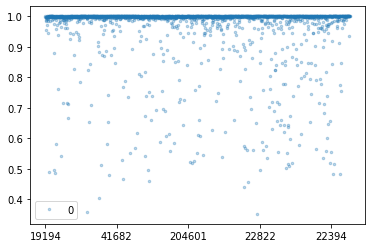

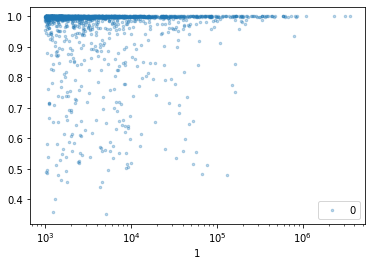

In [6]:
sorted_geo_all_dict = {k: v for k, v in sorted(geo_all_dict.items(), key=lambda item: item[1]["tot_nodes_count"]) if v["tot_nodes_count"] >= MIN_SIZE}


ratio_dict = dict()
for as_number, data in sorted_geo_all_dict.items():
    tot = data["tot_nodes_count"]
    ratio_dict[as_number] = max(data["NA_nodes_count"], data["SA_nodes_count"], data["EU_nodes_count"], data["AF_nodes_count"], data["AS_nodes_count"], data["OC_nodes_count"], data["AN_nodes_count"]) / tot
ratio_df = pd.DataFrame.from_dict(ratio_dict, orient="index")
ratio_df.plot(ls="", marker = ".", markersize=5, alpha=0.3)

ratio_dict_node_num = dict()
for as_number, data in sorted_geo_all_dict.items():
    tot = data["tot_nodes_count"]
    ratio_dict_node_num[as_number] = [
        max(data["NA_nodes_count"], data["SA_nodes_count"], data["EU_nodes_count"], data["AF_nodes_count"], data["AS_nodes_count"], data["OC_nodes_count"], data["AN_nodes_count"]) / tot,
        tot
    ]
ratio_node_num_df = pd.DataFrame.from_dict(ratio_dict_node_num, orient="index")
ratio_node_num_df.plot(ls="", marker = ".", markersize=5, x=1, alpha=0.3)
plt.xscale("log")

# first has just ASs ordered by size, second has x axis showing order of the AS

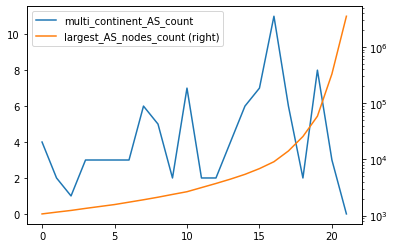

In [42]:
# chunks
def chunks(data, SIZE):
    it = iter(data)
    for i in range(0, len(data), SIZE):
        yield {k:data[k] for k in islice(it, SIZE)}

chunks_data = dict()
i = 0
for chunk in chunks(ratio_dict, 100):
    count = 0
    for as_number, value in chunk.items():
        if value < RATIO:
            count += 1
    chunks_data[i] = {
        "multi_continent_AS_count": count,
        "largest_AS_nodes_count": sorted_geo_all_dict[as_number]["tot_nodes_count"]
    }
    i += 1
chunks_df = pd.DataFrame.from_dict(chunks_data, orient="index")
with open("stats/geo_chunks.csv", "w", encoding="utf8") as out_file:
    chunks_df.to_csv(out_file)
ax = chunks_df.plot(secondary_y='largest_AS_nodes_count')
plt.yscale("log")

## dataframe with analysis data, for LCC coverage study

In [2]:
lcc_df = pd.read_csv("analysis_2020_08/analysis.tsv", delimiter="\t", index_col=0)[["ds_nodes","largest_cc_size", "largest_cc_coverage"]]
lcc_df

,ds_nodes,largest_cc_size,largest_cc_coverage
as_number,,,
42248,1000,1036,0.994242
19194,1000,876,0.859666
206866,1002,328,0.187536
6663,1002,4987,0.984989
13591,1002,2264,0.958510
...,...,...,...
209,674414,825689,0.988111
5607,737909,903661,0.979958
16625,797800,665171,0.781317


## 1 dataframe per continent

In [8]:
df_NA = pd.DataFrame()
df_SA = pd.DataFrame()
df_EU = pd.DataFrame()
df_AF = pd.DataFrame()
df_AS = pd.DataFrame()
df_OC = pd.DataFrame()
df_MANY = pd.DataFrame()
for index, row in lcc_df.iterrows():
    as_number = str(index)
    if as_number not in geo_dict:
        pass
    elif geo_dict[as_number] == "NA":
        df_NA = df_NA.append(row)
    elif geo_dict[as_number] == "SA":
        df_SA = df_SA.append(row)
    elif geo_dict[as_number] == "EU":
        df_EU = df_EU.append(row)
    elif geo_dict[as_number] == "AF":
        df_AF = df_AF.append(row)
    elif geo_dict[as_number] == "AS":
        df_AS = df_AS.append(row)
    elif geo_dict[as_number] == "OC":
        df_OC = df_OC.append(row)
    elif geo_dict[as_number] == "MANY":
        df_MANY = df_MANY.append(row)
df_NA.index.name = "as_number"
df_SA.index.name = "as_number"
df_EU.index.name = "as_number"
df_AF.index.name = "as_number"
df_AS.index.name = "as_number"
df_OC.index.name = "as_number"
df_MANY.index.name = "as_number"

# save to csv
with open("analysis_2020_08/lcc_NA.csv", "w", encoding="utf8") as out_file:
    df_NA.to_csv(out_file)
with open("analysis_2020_08/lcc_SA.csv", "w", encoding="utf8") as out_file:
    df_SA.to_csv(out_file)
with open("analysis_2020_08/lcc_EU.csv", "w", encoding="utf8") as out_file:
    df_EU.to_csv(out_file)
with open("analysis_2020_08/lcc_AF.csv", "w", encoding="utf8") as out_file:
    df_AF.to_csv(out_file)
with open("analysis_2020_08/lcc_AS.csv", "w", encoding="utf8") as out_file:
    df_AS.to_csv(out_file)
with open("analysis_2020_08/lcc_OC.csv", "w", encoding="utf8") as out_file:
    df_OC.to_csv(out_file)
with open("analysis_2020_08/lcc_MANY.csv", "w", encoding="utf8") as out_file:
    df_MANY.to_csv(out_file)

## plot distributions for every continent

<AxesSubplot:title={'center':'MANY'}>

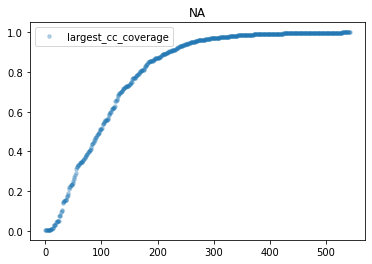

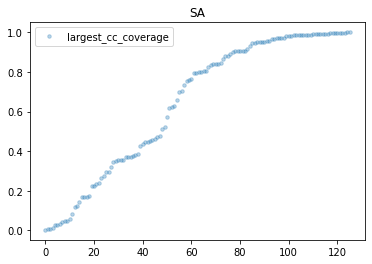

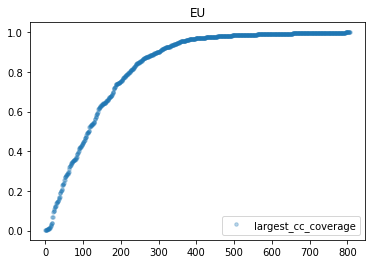

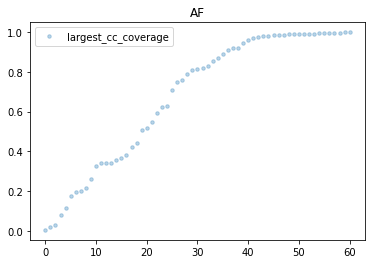

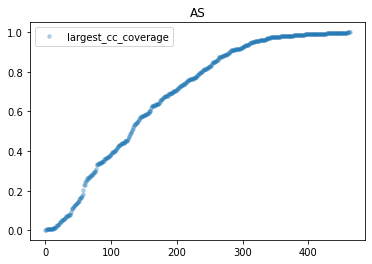

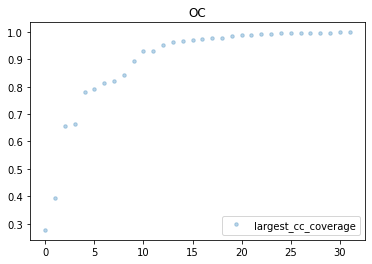

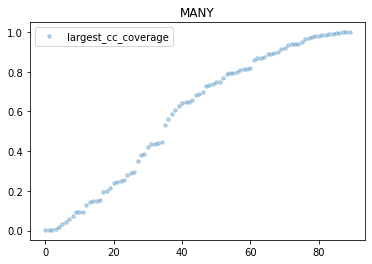

In [36]:
df = df_NA["largest_cc_coverage"].sort_values().reset_index().drop("index", axis=1)
df.plot(ls="", marker = ".", markersize=7, alpha=.3, title="NA")
df = df_SA["largest_cc_coverage"].sort_values().reset_index().drop("index", axis=1)
df.plot(ls="", marker = ".", markersize=7, alpha=.3, title="SA")
df = df_EU["largest_cc_coverage"].sort_values().reset_index().drop("index", axis=1)
df.plot(ls="", marker = ".", markersize=7, alpha=.3, title="EU")
df = df_AF["largest_cc_coverage"].sort_values().reset_index().drop("index", axis=1)
df.plot(ls="", marker = ".", markersize=7, alpha=.3, title="AF")
df = df_AS["largest_cc_coverage"].sort_values().reset_index().drop("index", axis=1)
df.plot(ls="", marker = ".", markersize=7, alpha=.3, title="AS")
df = df_OC["largest_cc_coverage"].sort_values().reset_index().drop("index", axis=1)
df.plot(ls="", marker = ".", markersize=7, alpha=.3, title="OC")
df = df_MANY["largest_cc_coverage"].sort_values().reset_index().drop("index", axis=1)
df.plot(ls="", marker = ".", markersize=7, alpha=.3, title="MANY")

## avg each continent

In [40]:
continents = dict()
for continent, count in continent_count.items():
    continent_dict = dict()
    for column in lcc_df.columns:
        continent_dict[column] = 0
    continent_dict["count"] = 0
    continents[continent] = continent_dict
for index, row in lcc_df.iterrows():
    as_number = str(index)
    if as_number not in geo_dict:
        continue
    continent = geo_dict[as_number]
    for column in lcc_df.columns:
        continents[continent][column] = continents[continent][column] + row[column]
    continents[continent]["count"] = continents[continent]["count"] + 1
# average
for continent, row in continents.items():
    for column, data in row.items():
        if row["count"] != 0 and column != "count":
            continents[continent][column] = data / row["count"]

continent_df = pd.DataFrame.from_dict(continents, orient="index").drop(["AN"])
continent_df

,ds_nodes,largest_cc_size,largest_cc_coverage,count
NA,22458.165746,32419.896869,0.793629,543
SA,17485.142857,19209.801587,0.644473,126
EU,15022.100372,18295.561338,0.824262,807
AF,12107.327869,13682.459016,0.678116,61
AS,17924.148707,24720.260776,0.682366,464
OC,11174.343750,30037.000000,0.890426,32
MANY,11177.766667,33062.177778,0.587528,90


## single country